In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm

In [2]:
def plotImages(image_original, image_corner):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
    ax1.imshow(image_original)
    ax1.set_title('image_original', fontsize=15)
    ax2.imshow(image_corner)
    ax2.set_title('image_corner', fontsize=15)

In [3]:
def camera_cal(img, nx, ny):
    
    # To map the coordinates of the corners in the 2D image (img in this case) called imgpoints to the 3D coordinates 
    # of the real, undistorted chessboard corners called objpoint
    
    imgpoints = [] # 2D coordinates in image plane    
    objpoints = [] # 3D coordinates in real world space

    
    objp = np.zeros((ny*nx, 3), np.float32)  # (54, 3) 54 points each with 3 columns for the x, y, z coordinates of each corner
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # (54, 3) They are filled as (0.,0.,0.), (1.,0.,0.), (2.,0.,0.) ..... (8.,5.,0.)
    
    for image_name in (images):
        image_original = mpimg.imread(image_name)

        # Convert to grayscale
        gray = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            image_corner = np.copy(image_original)
            cv2.drawChessboardCorners(image_corner, (nx, ny), corners, ret)
            plotImages(image_original, image_corner)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) # gray.shape[::-1] reverses shape from (720, 1280) to (1280, 720)
    # dist = distortion coefficients
    # mtx = camera matrix that we need to transform 3D object points to 2D image points
    # rvecs (rotation vector), tvecs (translation vector) = denotes position of the camera in the world

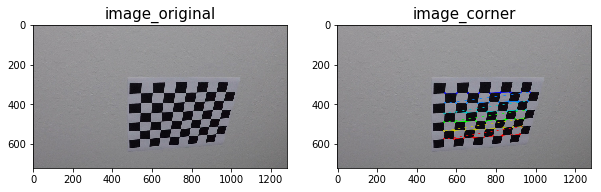

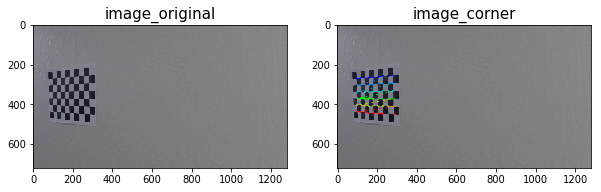

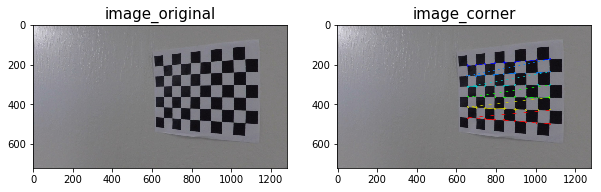

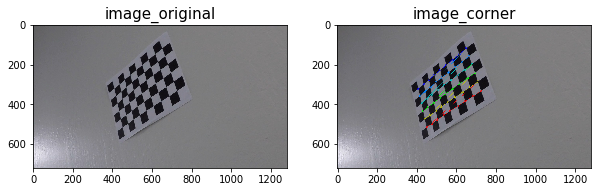

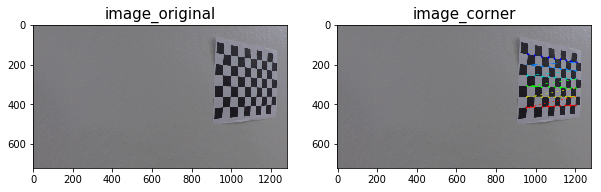

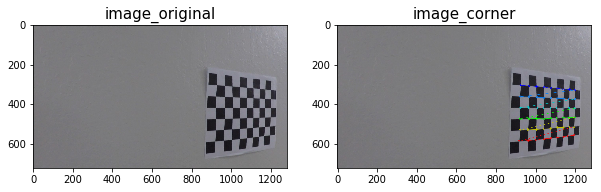

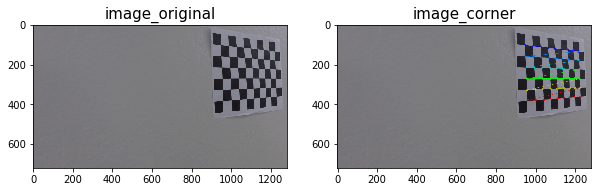

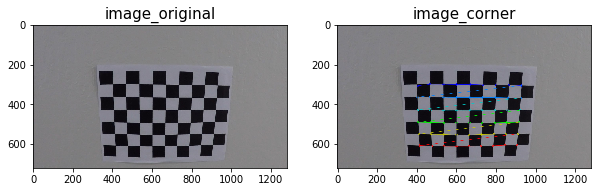

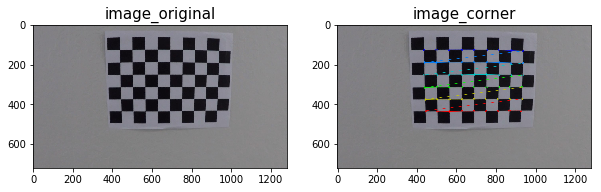

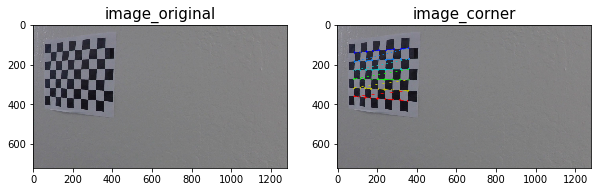

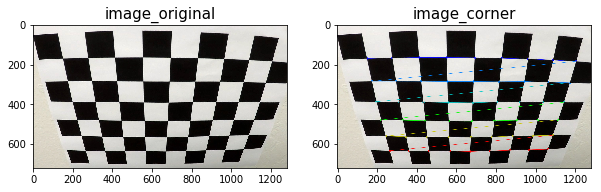

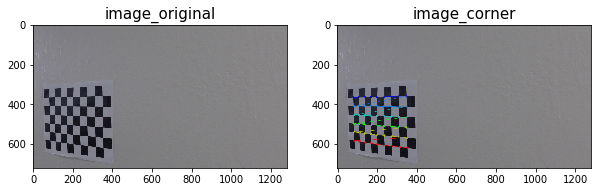

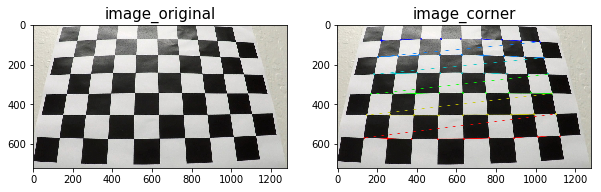

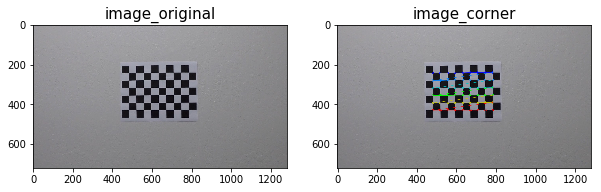

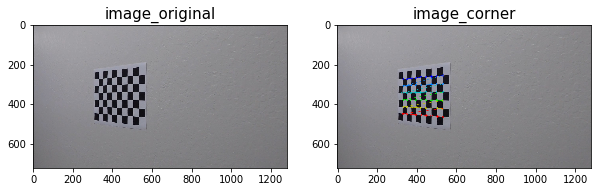

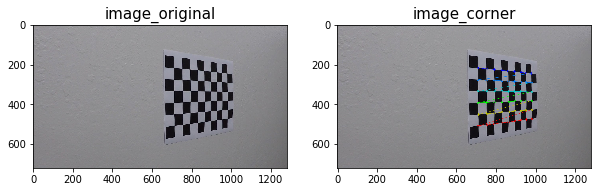

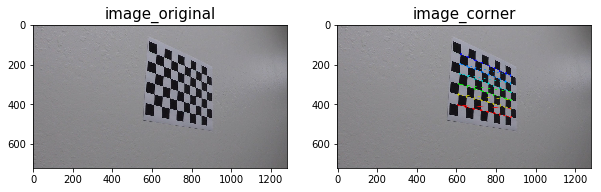

In [4]:
input_folder = 'camera_cal/'
nx = 9 #enter the number of inside corners in x
ny = 6 #enter the number of inside corners in y

images = glob(input_folder + '/*.jpg')
camera_cal(images, nx, ny)